In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import time

from plot_utils import regression_plot_with_uncertainty
from Prediction_bands import split_conformal_bands, weighted_split_conformal_prediction

In [2]:
# def split_conformal_bands(predictor, 
#                           X_test,  
#                           X_cal, 
#                           y_cal,
#                           qiantiles,
#                           alpha = 0.95
# ):
#     cal_mean_predictions = predictor.predict(X_cal)
#     S_score = np.abs(y_cal - cal_mean_predictions)
#     quantile = np.nanquantile(S_score, 1 - alpha, method = "higher")
    
#     mean_predictions = predictor.predict(X_test)
#     prediction_bands = np.stack([
#         mean_predictions - quantile,
#         mean_predictions + quantile
#     ], axis = 1)
    
#     return prediction_bands, quantile, mean_predictions

In [3]:
# def weighted_split_conformal_prediction(predictor, X_cal, y_cal, X_test, cal_weights, alpha=0.95):
#     """ Weighted Split Conformal Prediction (taken from github.io/code/nonexchangeable_conformal.zip) """

#     # normalize weights (we add +1 in the denominator for the test point at n+1)
#     weights_normalized = cal_weights / (np.sum(cal_weights)+1)

#     if(np.sum(weights_normalized) >= 1-alpha):
#         # calibration scores: |y_i - x_i @ betahat|
#         R = np.abs(y_cal - predictor.predict(X_cal))
#         ord_R = np.argsort(R)
#         # from when are the cumulative quantiles at least 1-\alpha
#         ind_thresh = np.min(np.where(np.cumsum(weights_normalized[ord_R])>=1-alpha))
#         # get the corresponding residual
#         quantile = np.sort(R)[ind_thresh]
#     else:
#         quantile = np.inf
    
#     # Standard prediction intervals using the absolute residual score quantile
#     mean_prediction = predictor.predict(X_test)
#     prediction_bands = np.stack([
#         mean_prediction - quantile,
#         mean_prediction + quantile
#     ], axis=1)

#     return mean_prediction, prediction_bands, quantile

In [4]:
def __start__pred__(X, Y, alpha, rho, train_lag, rho_ls, ntrial, N):
    methods = ["CP+LS", "NexCP+LS", "NexCP+WLS"]

    # Initialize prediction intervals
    PI_split_CP = np.zeros((len(methods), ntrial, N, 2))
    PI_split_CP[:, :, :train_lag, 0] = -np.inf
    PI_split_CP[:, :, :train_lag, 1] = np.inf

    # Main loop
    for trial in tqdm(np.arange(ntrial)):
        for pred_idx in range(train_lag, N):
            for method_idx, method in enumerate(methods):
                if method == "CP+LS":
                    weights = np.ones(pred_idx+1)
                    tags = np.ones(pred_idx)
                else:
                    weights = rho ** np.arange(pred_idx, 0, -1)
                    weights = np.r_[weights, 1]  # Fix append

                if method == "NexCP+WLS":
                    tags = rho_ls ** np.arange(pred_idx, -1, -1)
                else:
                    tags = np.ones(pred_idx + 1)  # Default tags for other methods

                idx_odd = np.arange(1, int(np.ceil(pred_idx / 2) * 2), 2)
                idx_even = np.arange(0, int(np.floor(pred_idx / 2) * 2), 2)

                predictor = LinearRegression()
                predictor.fit(X[idx_odd], Y[idx_odd], tags[idx_odd])  # Correct indexing

                mean_predictions, prediction_bands, quantile = weighted_split_conformal_prediction(
                    predictor,
                    X[idx_even],
                    Y[idx_even],
                    X[pred_idx][np.newaxis, :],  # Correct indexing
                    weights[idx_even],
                    alpha
                )

                PI_split_CP[method_idx, trial, pred_idx, :] = prediction_bands
    
    print("Finished processing.")
    return PI_split_CP

# SIMULATION STUDY
$$\textbf{Setting 1: i.i.d. data} X_i \sim \mathcal{N}(0, \textbf{I}_{4}) \text{  and  } Y_i \sim X_i^T\beta + \mathcal{N}(0, 1) $$

We first let $\beta = (2, 1, 0, 0)$


Generate data


In [5]:
np.random.seed(12345)
N = 2000
beta = [2, 1, 0, 0]
alpha = 0.1
ntrial = 200
train_lag = 100


rho = rho_ls = 0.99
# Data generation
X = np.random.normal(size = (ntrial, N, 4))
Y = np.zeros((ntrial, N))

noise = np.random.normal(size =(ntrial, N))

for i in np.arange(N):
    Y[:, i] = np.dot(X[:, i], beta) + noise[:, i]

In [9]:
Y.shape

(200, 2000)

In [18]:
from concurrent.futures import ThreadPoolExecutor

# Assuming weighted_split_conformal_prediction is defined elsewhere

def run_trial(itrial):
    for pred_idx in np.arange(train_lag, N):
        # we predict the point at pred_idx (n+1) starting at pred_idx=train_lag (101-th datapoint)

        for method_idx, method in enumerate(methods):
            # calibration weights for non-exchangeable conformal prediction (nexCP)
            if method in ['nexCP+LS', 'nexCP+WLS']:
                # weights at 1, ..., n (notice: in Python arrays this becomes 0, ..., n-1)
                weights = rho**(np.arange(pred_idx,0,-1))
                # weight n+1 should always be 1
                weights = np.r_[weights,1]
            else:
                weights = np.ones(pred_idx+1)
            
            # weights for weighted linear regression (WLS)
            if method == 'nexCP+WLS':
                # tags 1, ..., n+1
                tags = rho_LS**(np.arange(pred_idx,-1,-1))
            else:
                tags = np.ones(pred_idx+1)
                
            random_ind = int(np.where(np.random.multinomial(1,weights,1))[1])
            tags[np.c_[random_ind,n]] = tags[np.c_[n,random_ind]]

            # odd data points for training, even ones for calibration
            inds_odd = np.arange(1,int(np.ceil(pred_idx/2)*2-1),2) # excludes pred_idx
            inds_even = np.arange(2,int(np.floor(pred_idx/2)*2),2) # excludes pred_idx

            # train a weighted least squares regression (tags are the weights)
            predictor = LinearRegression()
            predictor.fit(X[itrial, inds_odd], Y[itrial, inds_odd], tags[inds_odd])

            mean_prediction, prediction_bands, quantile = weighted_split_conformal_prediction(
                predictor, # the trained weighted linear regression model
                X[itrial, inds_even], # calibration inputs
                Y[itrial, inds_even], # calibration targets
                X[itrial, pred_idx][np.newaxis, :], # test point to predict
                weights[inds_even], # calibration score weights
                alpha # target miscoverage rate
            )
            PI_split_CP[method_idx,itrial,pred_idx,:] = prediction_bands

# Multithreading part
ntrial = 200
N = 2000  
train_lag = 100
rho = 0.99
rho_LS = 0.99
alpha = 0.1
methods = ['CP+LS', 'nexCP+LS', 'nexCP+WLS']
PI_split_CP = np.zeros((len(methods),ntrial,N,2))
PI_split_CP[:, :, :train_lag, 0] = -np.inf
PI_split_CP[:, :, :train_lag, 1] = np.inf

with ThreadPoolExecutor(max_workers=5) as executor:
    list(tqdm(executor.map(run_trial, np.arange(ntrial)), total=ntrial))


  0%|          | 0/200 [00:00<?, ?it/s]

ValueError: sum(pvals[:-1]) > 1.0

In [7]:
PI_split_CP.shape

(3, 100, 2000, 2)

In [ ]:
methods = ["CP+LS", "NexCP+LS", "NexCP+WLS"]

In [13]:
coverage = np.zeros((len(methods), N - train_lag))
pi_width = np.zeros((len(methods), N - train_lag))

# compute coverage for each time step and trial
for method_idx, method in enumerate(methods):
    lower_bound = PI_split_CP[method_idx, :, train_lag:, 0]
    upper_bound = PI_split_CP[method_idx, :, train_lag:, 1]

    # Ensure that lower_bound, upper_bound, and Y[:, train_lag:] have the same shape
    assert lower_bound.shape == upper_bound.shape == Y[:, train_lag:].shape, \
        f"Shape mismatch: {lower_bound.shape}, {upper_bound.shape}, {Y[:, train_lag:].shape}"

    # coverage is averaged over ntrials
    coverage[method_idx] = np.mean((lower_bound <= Y[:, train_lag:]) & (upper_bound >= Y[:, train_lag:]), axis=0)
    pi_width[method_idx] = np.mean(upper_bound - lower_bound, axis=0)


In [11]:
Y[:, train_lag:].shape

(200, 1900)

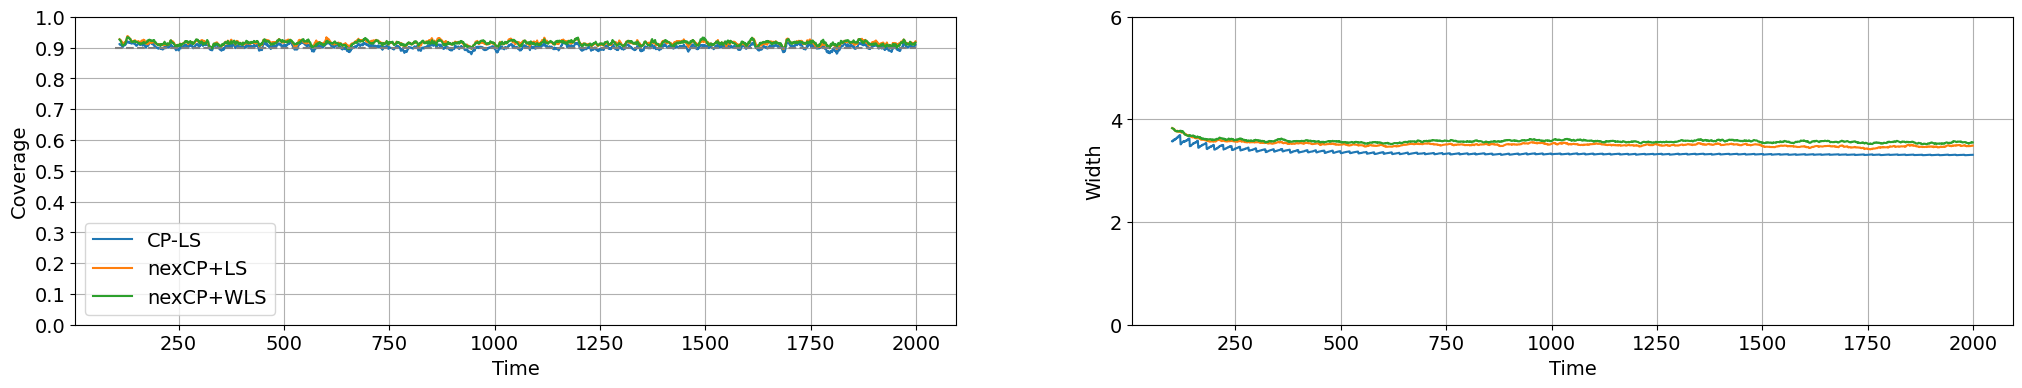

In [14]:
plt.rcParams.update({'font.size': 14})

window = 10 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x, np.ones(window)/window)[(window-1):-window]
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,4))

for method_idx, method in enumerate(methods):
    ax[0].plot(np.arange(train_lag+window,N), rolling_avg(coverage[method_idx], window))
    ax[1].plot(np.arange(train_lag, N), pi_width[method_idx])

ax[0].hlines(1-alpha, xmin=train_lag, xmax=N, linestyles='--', colors='gray')
ax[0].legend(['CP-LS','nexCP+LS','nexCP+WLS'])

ax[0].set_ylabel('Coverage')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[0].set_xlabel('Time')
ax[0].grid(True)

ax[1].set_ylabel('Width')
ymax = np.max([
    pi_width[method_idx].max() for method_idx in range(len(methods))
]) * 1.1
ax[1].set_ylim([0, ymax])
ax[1].set_yticks([0, 2, 4, 6])
ax[1].set_xlabel('Time')
ax[1].grid(True)

plt.show()

In [15]:
for method_idx, method in enumerate(methods):
    print(f'{method}')
    print('-'*10)
    print(f'Avg. coverage: {np.mean(coverage[method_idx]):.3f}')
    print(f'Avg. interval width: {np.mean(pi_width[method_idx]):.2f}')
    print()

CP+LS
----------
Avg. coverage: 0.902
Avg. interval width: 3.35

nexCP+LS
----------
Avg. coverage: 0.915
Avg. interval width: 3.51

nexCP+WLS
----------
Avg. coverage: 0.915
Avg. interval width: 3.58

